# Exercise 3: Analysis of responses to stimuli
version 19May2022
**Goal:** Examine how neurons respond to stimuli sinusoidal AMs (SAMs), random AMs (RAMs), and envelopes.

## A) REPEAT: Load data 
If necessary, reload the data for this script.

In [2]:
import numpy as np
from util import load_data

filename = "data/ELL_Envelopes_4v6.mat"
data = load_data(filename)

## B) REPEAT: Extract spike times from the membrane potential
If you don't have the spiketimes, re-run this.

(-50.0, 100.0)

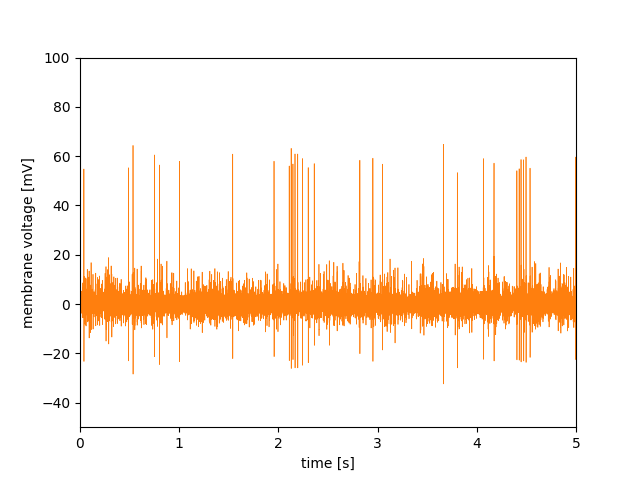

Clicked coordinates (0.030241935483870885, 27.597402597402578)


In [3]:
import matplotlib.pyplot as plt
%matplotlib widget

from scipy.signal import butter, filtfilt

coords = []

def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata

    global coords
    coords.append((ix, iy))
    if len(coords) == 2:
        fig.canvas.mpl_disconnect(cid)
    print(f"Clicked coordinates {(ix, iy)}")
    return coords


# hig-pass filter to remove slow membrane potential changes.
b, a = butter(2, 200, 'high', fs=data.fs)
vm_filtered = filtfilt(b, a, data.vm);

fig = plt.figure()
cid = fig.canvas.mpl_connect('button_press_event', onclick)
ax = fig.add_subplot(111)
ax.plot(data.time, vm_filtered, lw=0.5, color="tab:orange", label="filtered")
ax.set_xlabel("time [s]")
ax.set_ylabel("membrane voltage [mV]")
ax.set_xlim(0, 5.0)
ax.set_ylim(-50, 100)

### Select the threshold and detect spikes

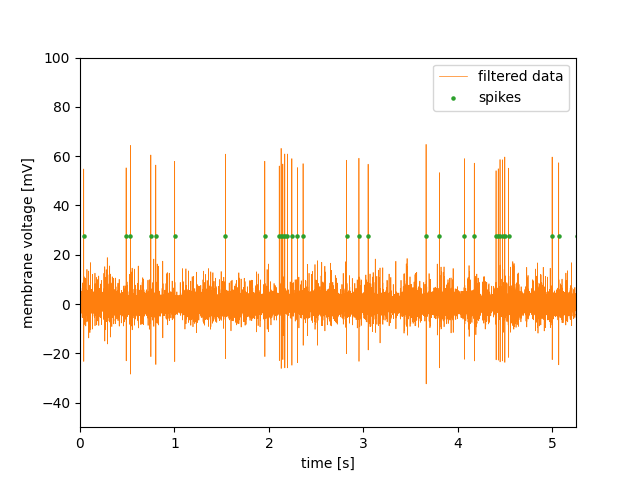

In [4]:
from util import threshold_crossing

threshold = coords[-1][-1]
spike_times, _ = threshold_crossing(vm_filtered, data.time, threshold)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(data.time, vm_filtered, lw=0.5, label="filtered data", color="tab:orange",
         zorder=0)
ax.scatter(spike_times, np.ones_like(spike_times) * threshold, s=5, c="tab:green", 
           label="spikes", zorder=1)
ax.set_xlabel("time [s]")
ax.set_ylabel("membrane voltage [mV]")
ax.set_xlim(0., 5.25)
ax.set_ylim(-50, 100)
ax.legend()

In [5]:
baseline_duration = min([data.comment_times[0], 20.]);
baseline_spikes = spike_times[spike_times < baseline_duration]
baserate = len(baseline_spikes) / baseline_duration
print(f"Baseline firing rate: {len(baseline_spikes)/baseline_duration:.2f} Hz")

Baseline firing rate: 6.20 Hz


## C) SAMs: Responses to sinusoidal AMs  
Now look at how receptor afferents (EAs) respond to sinusoidal AMs. This code works with SAM data.
We’ll be looking for the following: 

* Are neurons sensitive to different SAM frequencies?
* Are neurons sensitive to different SAM amplitudes or, equivalently, are they sensitive to the contrast of the SAM relative to the baseline EOD amplitude? 

To do this, you’ll first need to select the beginning and end times of the SAM at a given frequency (e.g., 2 Hz) (i.e., the trigtimes) and the corresponding spike times. 
We will perform 3 analyses: we will make an approximation of the firing rate in an analoge signal, we will plot a phase histogram, and calculate vector strength.
### 1)  SAMs: Instantaneous firing rate using a low pass filter

[302.253715 306.173575 310.412945 313.718395 322.614895 323.432085
 331.191955 352.702075 371.195515 375.324295]


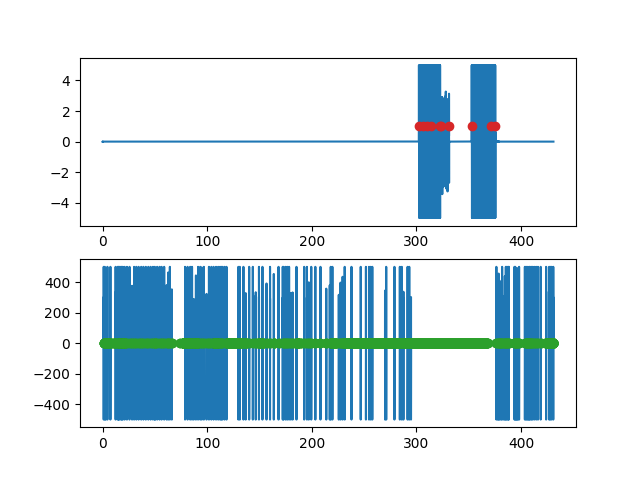

In [125]:
from scipy.signal import welch, filtfilt, butter


# Select the SAM segment
punit_data = load_data("data/punt_AMs_noisev6.mat")

print(punit_data.comment_times)
segment_starts = punit_data.comment_times
spike_times, _ = threshold_crossing(punit_data.vm, punit_data.time, 2.0)

fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(punit_data.am_time, punit_data.am)
ax.scatter(punit_data.comment_times, np.ones_like(punit_data.comment_times), color="tab:red", zorder=2)

ax2 = fig.add_subplot(212, sharex=ax)
ax2.plot(punit_data.time, punit_data.vm)
ax2.scatter(spike_times, np.ones_like(spike_times), color="tab:green", zorder=2)
plt.show()

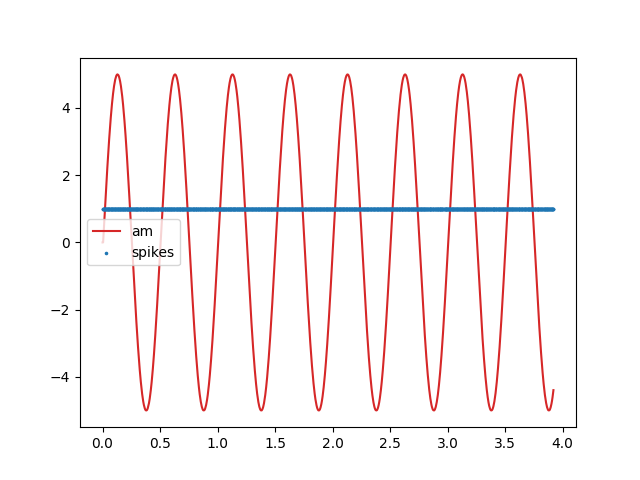

In [129]:
start_time = punit_data.comment_times[0]
end_time = punit_data.comment_times[1]

am_segment = punit_data.am[(punit_data.am_time >= start_time) & (punit_data.am_time < end_time)]
segment_time = np.arange(len(am_segment)) / punit_data.amfs
spikes_segment = spike_times[(spike_times >= start_time) & (spike_times < end_time)] - start_time

#create binary representation of spike response
spikes_binary = np.zeros_like(am_segment)
spikes_binary[np.asarray(spikes_segment * punit_data.amfs, dtype=int)] = 1

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(segment_time, am_segment, color="tab:red", label="am")
ax.scatter(spikes_segment, np.ones_like(spikes_segment), color="tab:blue", 
           label="spikes", zorder=2, s=2.5)
ax.legend()

Stimulus am frequency 2.0


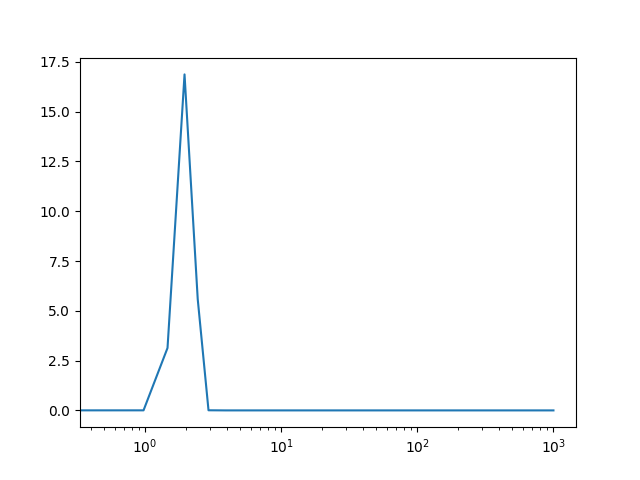

In [130]:
# Get the AM spectrum using the power specturm, wow, this is complicated
f, p = am_fft = welch(am_segment, punit_data.amfs, nperseg=2**12, noverlap=2**11)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogx(f, p)
am_freq = np.round(f[np.argmax(p)])
print(f"Stimulus am frequency {am_freq}")

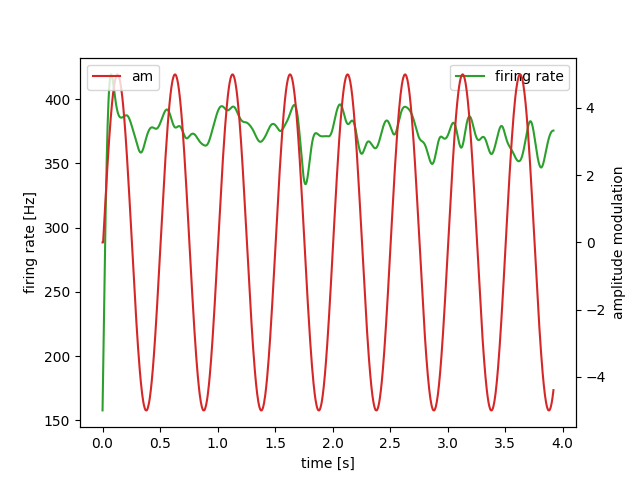

In [131]:
# Lowpass filter the response at cutoff 5 Hz greater than desired stimulus frequency
b, a = butter(3, (am_freq + 5), 'low', fs=punit_data.amfs)
firingrate_timedependent = filtfilt(b, a, spikes_binary * punit_data.amfs)

fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax.plot(segment_time, firingrate_timedependent, color="tab:green", label="firing rate")
ax.set_ylabel("firing rate [Hz]")
ax.set_xlabel("time [s]")
ax2.plot(segment_time, am_segment, color="tab:red", label="am")
ax2.set_ylabel("amplitude modulation")
ax.legend()
ax2.legend(loc=2)

### 2) SAMs: Phase histogram 
Compute a phase histogram in response to the SAM. We will perform the same analysis that we did for phase locking to the EOD. Before that can happen, we need to extract the cycle starts, like EOD0Xings was for the EOD.  

/tmp/ipykernel_48256/3999735368.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["0", r"$\frac{1}{4}\pi$", r"$\frac{1}{2}\pi$",


[]

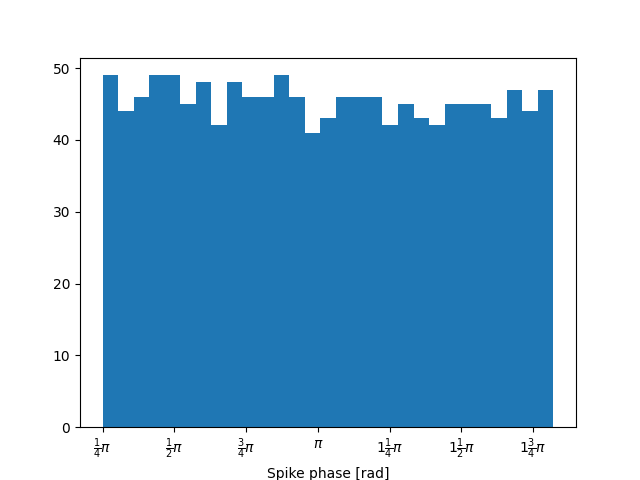

In [132]:
# Detect the rising flanks in the am
am_times, _ = threshold_crossing(am_segment, segment_time, 0.025)
# am_times = np.append(am_times, segment_time[-1])

# we need to be careful here and ignore all spikes that are before the first am period and after the last am time

valid_spikes = spikes_segment[(spikes_segment > am_times[0]) & (spikes_segment < am_times[-1])]
indices = np.searchsorted(am_times, valid_spikes)
starts = am_times[indices - 1]
ends = am_times[indices]

delays_abs = valid_spikes - starts
delays_rel = delays_abs / (ends - starts)
phases = delays_rel * 2 * np.pi

# Plot phase distribution
numbins = 30  # Number of bins for the histogram (60 is default)
bins = np.linspace(0, 2 * np.pi, numbins)
h, n = np.histogram(phases, bins)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(bins[:-1] + np.diff(bins)/2, h, width=np.diff(bins)[0])
ax.set_xticklabels(["0", r"$\frac{1}{4}\pi$", r"$\frac{1}{2}\pi$",
                    r"$\frac{3}{4}\pi$", "$\pi$", r"1$\frac{1}{4}\pi$",
                    r"1$\frac{1}{2}\pi$", r"$1\frac{3}{4}\pi$"])
ax.set_xlabel("Spike phase [rad]")
plt.plot()

### D) RAMs: Responses to noisy stimuli 
To interpret the responses to RAMs, we first repeat the initial step from the previous section by identifying a stimulus epoch. Once we narrow our range to the stimulus event, we can then compute the coherence between the AM and the response.

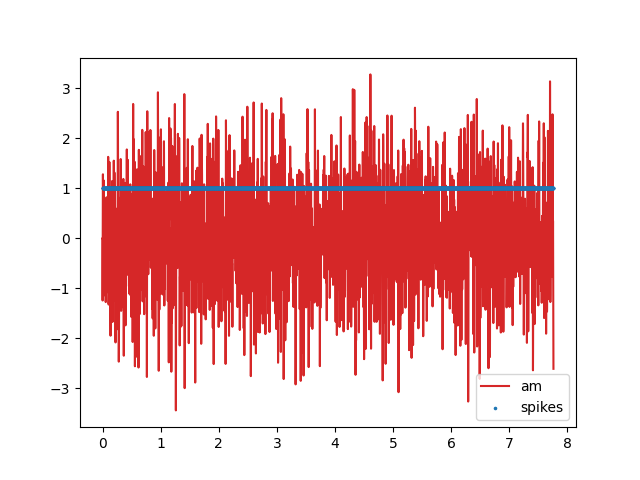

In [133]:
# for the test file used here it is the segment between the 6th and 7th marker

start_time = punit_data.comment_times[5]
end_time = punit_data.comment_times[6]

am_segment = punit_data.am[(punit_data.am_time >= start_time) & (punit_data.am_time < end_time)]
segment_time = np.arange(len(am_segment)) / punit_data.amfs
spikes_segment = spike_times[(spike_times >= start_time) & (spike_times < end_time)] - start_time

#create binary representation of spike response
spikes_binary = np.zeros_like(am_segment)
spikes_binary[np.asarray(spikes_segment * punit_data.amfs, dtype=int)] = 1

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(segment_time, am_segment, color="tab:red", label="am")
ax.scatter(spikes_segment, np.ones_like(spikes_segment), color="tab:blue", 
           label="spikes", zorder=2, s=2.5)
ax.legend()

####  1) RAMs: Coherence

Text(0, 0.5, 'coherence')

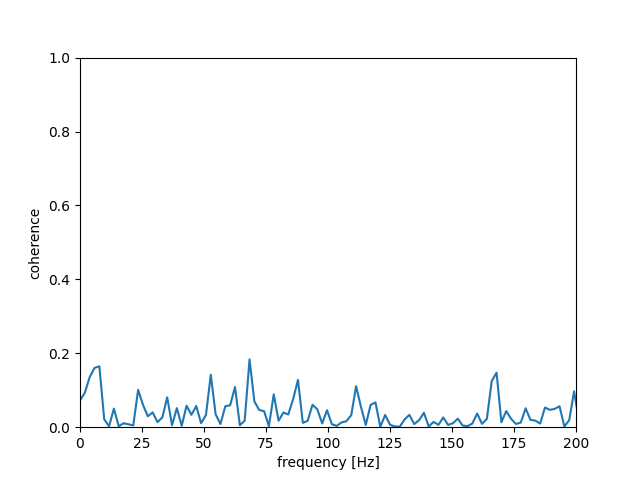

In [156]:
from scipy.signal import coherence
f, c = coherence(am_segment, spikes_binary, fs=punit_data.amfs, nperseg=2**10, noverlap=2**9)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(f, c, label="coherence")
ax.set_xlim([0., 200.]) # we adjust the xlimits to the spectral content of the stimulus
ax.set_ylim([0.0, 1.0]) # the coherence is a correlation measure that varies between 0 and 1.
ax.set_xlabel("frequency [Hz]")
ax.set_ylabel("coherence")

### 2) RAMs: Spike Triggered Average
As the name suggests, the spike triggered average stimulus is the average stimulus that leads to a spike response in the neuron.
This can be estimated by taking a snippet of the stimulus that is centered around each spike and then average these stimulus segments.

Text(0, 0.5, 'stimulus amplitude')

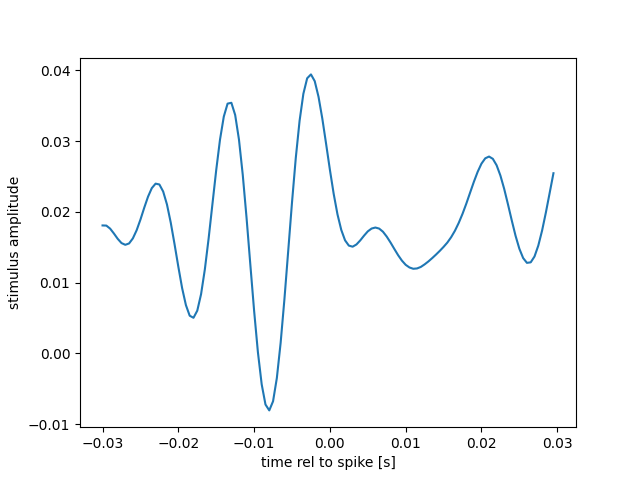

In [142]:
offset = 0.03 

sta_time = np.arange(-offset, offset, 1/punit_data.amfs)
spikes = spikes_segment[(spikes_segment > offset) & (spikes_segment < (segment_time[-1] - offset)) ]
stas = np.zeros((len(sta_time), len(spikes)))
for i, sp in enumerate(spikes):
    start_index = int(np.round((sp - offset) * punit_data.amfs))
    end_index = start_index + len(sta_time)
    stas[:, i] = am_segment[start_index:end_index]
sta = np.mean(stas, axis=1)
error = np.std(stas, axis=1)/np.sqrt(len(spikes))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sta_time, sta, label="spike triggered average stimulus")
ax.set_xlabel("time rel. to spike [s]")
ax.set_ylabel("stimulus amplitude")

## E) Envelopes: Response to contrast modulated SAMs 
Let’s see if the cells can track the instantaneous stimulus intensity or envelope.

### 1) Envelopes: Instantaneous firing rate using a low pass filter
First select the correct segment of AM and spike response and create the binary representation of the spiking response.

(-3.0, 3.0)

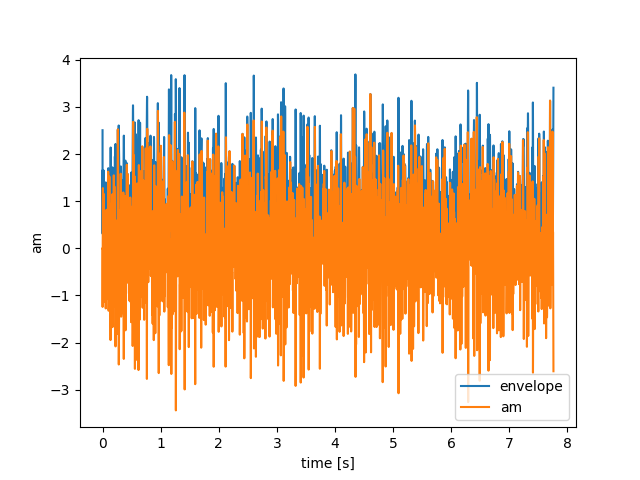

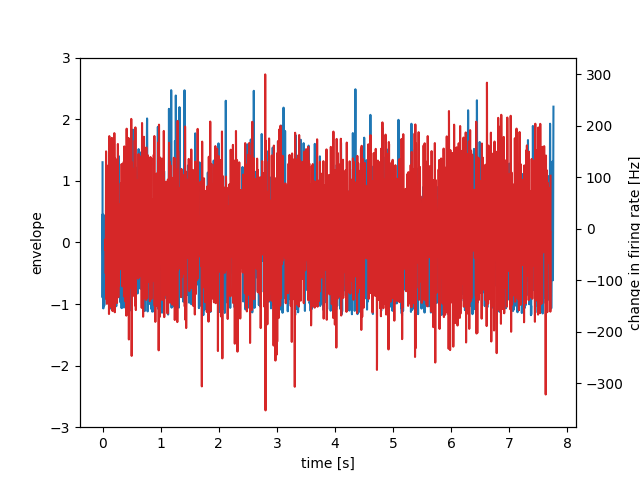

In [167]:
# we rely on the data loaded in the previous task

# extract the envelope from the am using the Hilbert transform
from scipy.signal import hilbert
env = np.abs(hilbert(am_segment - np.mean(am_segment)))
# plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(segment_time, env, label="envelope")
ax.plot(segment_time, am_segment, label="am")
ax.set_xlabel("time [s]")
ax.set_ylabel("am")
ax.legend()

# filter the spiking response with a 5 Hz low-pass filter
b, a = butter(3, 100, 'low', fs=punit_data.amfs)
firingrate_timedependent = filtfilt(b, a, spikes_binary * punit_data.amfs)


# plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax.plot(segment_time, env-np.mean(env), label="envelope")
ax2.plot(segment_time[100:-100], firingrate_timedependent[100:-100] - np.mean(firingrate_timedependent[100:-100]), color="tab:red")
ax.set_xlabel("time [s]")
ax.set_ylabel("envelope")
ax2.set_ylabel("change in firing rate [Hz]")
ax.set_ylim([-3, 3])

Does the firing rate track the envelope? Try looking at this under different conditions (i.e., for different stimulus intensities). 

### 2) Envelopes: Coherence

Text(0, 0.5, 'coherence')

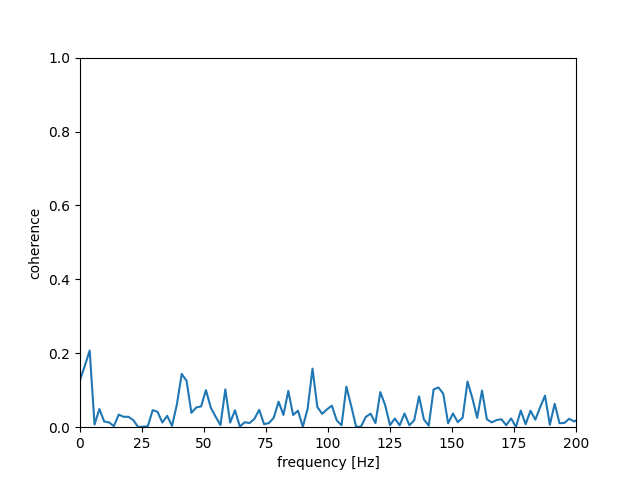

In [155]:
f, c = coherence(env, firingrate_timedependent, fs=punit_data.amfs, nperseg=2**10, noverlap=2**9)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(f, c, label="coherence")
ax.set_xlim([0., 200.]) # we adjust the xlimits to the spectral content of the stimulus
ax.set_ylim([0.0, 1.0]) # the coherence is a correlation measure that varies between 0 and 1.
ax.set_xlabel("frequency [Hz]")
ax.set_ylabel("coherence")